In [1]:
import openai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import googlemaps
import math
from flask import Flask, request, jsonify, render_template
from IPython.display import IFrame, display, HTML
from dotenv import load_dotenv
import os
import requests
import time
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

# Load environment variables from the .env file
load_dotenv(dotenv_path='/Users/irisyu/Desktop/Project/virtual-housing-agent/.env')

# Access the variables
DATA_API_KEY = os.getenv('DATA_API_KEY')
MAPS_API_KEY = os.getenv('PLACES_API_KEY')
GEOCODING_KEY = os.getenv('GEOCODING_API_KEY')
OPENAI_KEY = os.getenv('OPENAI_API_KEY')
openai.api_keys = OPENAI_KEY

In [7]:
res = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    messages=[{
        "role":"system",
        "content":"You are a virtual San Francisco housing rental agent. Your role is to assist users in finding the perfect rental property by asking for their requirements, preferences, and priorities. Guide the conversation through several stages: gathering basic requirements, understanding preferences, discussing lifestyle needs. Be friendly, informative, and attentive to the user's needs. You always wait for the user's response before proceeding to the next question or step. Do not generate multiple responses without user input. Wait for the user to respond before moving on. At the very beginning of conversation with users, you could just say “Welcome to the San Francisco Virtual Housing Agent! I'm here to help you find the perfect rental property in San Francisco. Let's start by getting to know your needs and preferences. "
    }]
)

output = res.choices[0].message.content
print(output)

Welcome to the San Francisco Virtual Housing Agent! I'm here to help you find the perfect rental property in San Francisco. Let's start by getting to know your needs and preferences. 

To begin, could you please share with me your basic requirements for a rental property in San Francisco? This would include the number of bedrooms you need, your preferred move-in date, and your budget range.


In [12]:
func_descrip = [{
    "name":"get_property_recommendations",
    "description":"Get property recommendations based on user requirements",
    "parameters":{
        "type":"object",
        "properties":{
            "bedrooms": {
                "type": "integer",
                "description": "Number of bedrooms required"},
            "bathrooms": {
                "type": "integer",
                "description": "Number of bathrooms required"},
            "min_rent": {
                "type": "number",
                "description": "Minimum monthly rent budget"},
            "max_rent": {
                "type": "number",
                "description": "Maximum monthly rent budget"},
            "location": {
                "type": "string",
                "description": "Desired location or neighborhood"},
            "lease_term": {
                "type": "integer",
                "description": "Desired lease term in months"},
            "max_distance_km": {
                "type": "number",
                "description": "Maximum distance from desired location in kilometers"},
            "amenities": {
                "type": "array",
                "items": {"type": "string"},
                "description": "List of required amenities"},
            "move_in_date": {
                "type": "string",
                "description": "Desired move-in date (YYYY-MM-DD format)"},
            "lifestyle_preferences": {
                "type": "object",
                "properties": {
                    "neighborhood_type": {
                        "type": "string",
                        "enum": ["quiet","lively"],
                "description": "Preferred type of neighborhood"},
            "nearby_facilities": {
                "type": "array",
                "items": {"type": "string"},
                "description": "Desired nearby facilities (e.g., restaurants, parks)"},
            "max_commute_time": {
                "type": "integer",
                "description": "Maximum acceptable commute time in minutes"},
            "furnished": {
                "type": "boolean",
                "description": "Whether a furnished apartment is required"},
            "roommate_friendly": {
                "type": "boolean",
                "description": "Whether the setup should be roommate-friendly"},
            "accessibility_needs": {
                "type": "array",
                "items": {"type": "string"},
                "description": "List of any accessibility requirements"}
        }
      }
    },
    "required": [
      "bedrooms",
      "bathrooms",
      "min_rent",
      "max_rent",
      "location"
    ]
  }
}]

In [13]:
user_prompt = "I want to find a 1 bedroom 1 bathroom near University of San Francisco"

res=openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{
        "role":"user",
        "content":"user_prompt"
    }],
    functions=func_descrip,
    function_call="auto"
)
print(res)

{
  "id": "chatcmpl-9i8GoDQ7gW6ekFBiAljbhoGQIQgZW",
  "object": "chat.completion",
  "created": 1720305250,
  "model": "gpt-3.5-turbo-0125",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "How can I assist you today?"
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 258,
    "completion_tokens": 8,
    "total_tokens": 266
  },
  "system_fingerprint": null
}


# Database

In [2]:
Data_URL = 'https://api.rentcast.io/v1/listings/rental/long-term'

In [3]:
params = {
    'city': 'San Francisco',
    'state': 'CA',
    'limit': 500,
    'status': 'Active', 
    'offset': 0
}

headers = {
    'Accept': 'application/json',
    'X-Api-Key': DATA_API_KEY
}

max_requests = 500  
all_listings = []
request_count = 0

In [4]:
try:
    for _ in range(max_requests):
        response = requests.get(Data_URL, headers=headers, params=params)
        request_count += 1
        
        if response.status_code == 200:
            listings = response.json() 
            if not isinstance(listings, list):
                print("Unexpected data format received.")
                break
            
            all_listings.extend(listings)
            
            print(f"Retrieved {len(listings)} rental listings. Total: {len(all_listings)}")
            
            if len(listings) < params['limit']:
                break
            
            params['offset'] += len(listings)
        else:
            print(f"Error: {response.status_code}")
            print(response.text)
            break
        
        time.sleep(1)

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print(f"\nData retrieval completed.")
print(f"Total retrieved rental listings: {len(all_listings)}")
print(f"Total API requests made: {request_count}")


df = pd.DataFrame(all_listings)

Retrieved 500 rental listings. Total: 500
Retrieved 500 rental listings. Total: 1000
Retrieved 334 rental listings. Total: 1334

Data retrieval completed.
Total retrieved rental listings: 1334
Total API requests made: 3


In [5]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1334 non-null   object 
 1   formattedAddress  1334 non-null   object 
 2   addressLine1      1334 non-null   object 
 3   addressLine2      668 non-null    object 
 4   city              1334 non-null   object 
 5   state             1334 non-null   object 
 6   zipCode           1334 non-null   object 
 7   county            1334 non-null   object 
 8   latitude          1334 non-null   float64
 9   longitude         1334 non-null   float64
 10  propertyType      1334 non-null   object 
 11  bathrooms         1289 non-null   float64
 12  squareFootage     793 non-null    float64
 13  status            1334 non-null   object 
 14  price             1334 non-null   int64  
 15  listedDate        1334 non-null   object 
 16  removedDate       0 non-nul

In [6]:
df.head()

,id,formattedAddress,addressLine1,addressLine2,city,state,zipCode,county,latitude,longitude,...,status,price,listedDate,removedDate,createdDate,lastSeenDate,daysOnMarket,bedrooms,yearBuilt,lotSize
0,"285-Turk-St,-Apt-502,-San-Francisco,-CA-94102","285 Turk St, Apt 502, San Francisco, CA 94102",285 Turk St,Apt 502,San Francisco,CA,94102,San Francisco,37.782658,-122.413765,...,Active,1995,2024-06-01T00:00:00.000Z,None,2024-06-01T00:00:00.000Z,2024-07-06T03:41:11.049Z,37,NaN,NaN,NaN
1,"631-Ofarrell-St,-Apt-616,-San-Francisco,-CA-94109","631 Ofarrell St, Apt 616, San Francisco, CA 94109",631 Ofarrell St,Apt 616,San Francisco,CA,94109,San Francisco,37.785240,-122.415120,...,Active,2100,2023-07-08T00:00:00.000Z,None,2019-12-26T08:52:04.986Z,2024-07-06T03:41:11.048Z,366,1.0,1930.0,NaN
2,"851-Van-Ness-Ave,-San-Francisco,-CA-94109","851 Van Ness Ave, San Francisco, CA 94109",851 Van Ness Ave,None,San Francisco,CA,94109,San Francisco,37.783520,-122.421355,...,Active,3995,2023-07-08T00:00:00.000Z,None,2020-06-13T03:44:37.452Z,2024-07-06T03:41:11.047Z,366,2.0,2003.0,NaN
3,"26-Portola-Dr,-San-Francisco,-CA-94131","26 Portola Dr, San Francisco, CA 94131",26 Portola Dr,None,San Francisco,CA,94131,San Francisco,37.750124,-122.443987,...,Active,5500,2024-06-27T00:00:00.000Z,None,2024-06-27T00:00:00.000Z,2024-07-06T03:41:11.047Z,11,3.0,NaN,NaN
4,"1390-Market-St,-Ste-107,-San-Francisco,-CA-94102","1390 Market St, Ste 107, San Francisco, CA 94102",1390 Market St,Ste 107,San Francisco,CA,94102,San Francisco,37.776763,-122.417425,...,Active,2266,2023-07-08T00:00:00.000Z,None,2020-04-10T02:51:30.033Z,2024-07-06T03:41:11.046Z,366,0.0,NaN,NaN


# Data Processing

In [7]:
columns_to_drop = ['id', 'addressLine1','addressLine2', 'state', 'lotSize','listedDate','removedDate']
df = df.drop(columns=columns_to_drop)

df = df.drop_duplicates()

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bathrooms,squareFootage,status,price,createdDate,lastSeenDate,daysOnMarket,bedrooms,yearBuilt
0,"285 Turk St, Apt 502, San Francisco, CA 94102",San Francisco,94102,San Francisco,37.782658,-122.413765,Apartment,1.0,434.0,Active,1995,2024-06-01T00:00:00.000Z,2024-07-06T03:41:11.049Z,37,NaN,NaN
1,"631 Ofarrell St, Apt 616, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.785240,-122.415120,Condo,1.0,480.0,Active,2100,2019-12-26T08:52:04.986Z,2024-07-06T03:41:11.048Z,366,1.0,1930.0
2,"851 Van Ness Ave, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.783520,-122.421355,Condo,2.0,965.0,Active,3995,2020-06-13T03:44:37.452Z,2024-07-06T03:41:11.047Z,366,2.0,2003.0
3,"26 Portola Dr, San Francisco, CA 94131",San Francisco,94131,San Francisco,37.750124,-122.443987,Single Family,1.5,1402.0,Active,5500,2024-06-27T00:00:00.000Z,2024-07-06T03:41:11.047Z,11,3.0,NaN
4,"1390 Market St, Ste 107, San Francisco, CA 94102",San Francisco,94102,San Francisco,37.776763,-122.417425,Apartment,1.0,NaN,Active,2266,2020-04-10T02:51:30.033Z,2024-07-06T03:41:11.046Z,366,0.0,NaN


In [8]:
from scipy import stats

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df[col] = df[col].fillna(0)


categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'addressLine2':
        df[col] = df[col].fillna("Unknown")


if 'removedDate' in df.columns:
    df['removedDate'] = df['removedDate'].fillna("Not Removed")


def remove_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores < 3]

for col in numeric_columns:
    df = remove_outliers(df, col)

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bathrooms,squareFootage,status,price,createdDate,lastSeenDate,daysOnMarket,bedrooms,yearBuilt
0,"285 Turk St, Apt 502, San Francisco, CA 94102",San Francisco,94102,San Francisco,37.782658,-122.413765,Apartment,1.0,434.0,Active,1995,2024-06-01T00:00:00.000Z,2024-07-06T03:41:11.049Z,37,0.0,0.0
1,"631 Ofarrell St, Apt 616, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.785240,-122.415120,Condo,1.0,480.0,Active,2100,2019-12-26T08:52:04.986Z,2024-07-06T03:41:11.048Z,366,1.0,1930.0
2,"851 Van Ness Ave, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.783520,-122.421355,Condo,2.0,965.0,Active,3995,2020-06-13T03:44:37.452Z,2024-07-06T03:41:11.047Z,366,2.0,2003.0
3,"26 Portola Dr, San Francisco, CA 94131",San Francisco,94131,San Francisco,37.750124,-122.443987,Single Family,1.5,1402.0,Active,5500,2024-06-27T00:00:00.000Z,2024-07-06T03:41:11.047Z,11,3.0,0.0
4,"1390 Market St, Ste 107, San Francisco, CA 94102",San Francisco,94102,San Francisco,37.776763,-122.417425,Apartment,1.0,0.0,Active,2266,2020-04-10T02:51:30.033Z,2024-07-06T03:41:11.046Z,366,0.0,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1222 entries, 0 to 1333
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1222 non-null   object 
 1   city              1222 non-null   object 
 2   zipCode           1222 non-null   object 
 3   county            1222 non-null   object 
 4   latitude          1222 non-null   float64
 5   longitude         1222 non-null   float64
 6   propertyType      1222 non-null   object 
 7   bathrooms         1222 non-null   float64
 8   squareFootage     1222 non-null   float64
 9   status            1222 non-null   object 
 10  price             1222 non-null   int64  
 11  createdDate       1222 non-null   object 
 12  lastSeenDate      1222 non-null   object 
 13  daysOnMarket      1222 non-null   int64  
 14  bedrooms          1222 non-null   float64
 15  yearBuilt         1222 non-null   float64
dtypes: float64(6), int64(2), object(8)
memory usage

# Exploratory Data Analysis

In [10]:
df.describe()

,latitude,longitude,bathrooms,squareFootage,price,daysOnMarket,bedrooms,yearBuilt
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,37.779536,-122.421893,1.172259,483.761866,3428.463175,117.498363,1.251227,537.472177
std,0.017156,0.020883,0.491525,547.732924,1459.128259,132.115632,0.975487,878.838753
min,37.719715,-122.493681,0.000000,0.000000,1035.000000,1.000000,0.000000,0.000000
25%,37.772846,-122.430383,1.000000,0.000000,2395.000000,22.000000,1.000000,0.000000
50%,37.783383,-122.418365,1.000000,413.000000,3150.000000,65.000000,1.000000,0.000000
75%,37.790744,-122.410687,1.000000,800.000000,4115.000000,142.750000,2.000000,1907.000000
max,37.811424,-122.365562,3.000000,3786.000000,9000.000000,366.000000,4.000000,2022.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


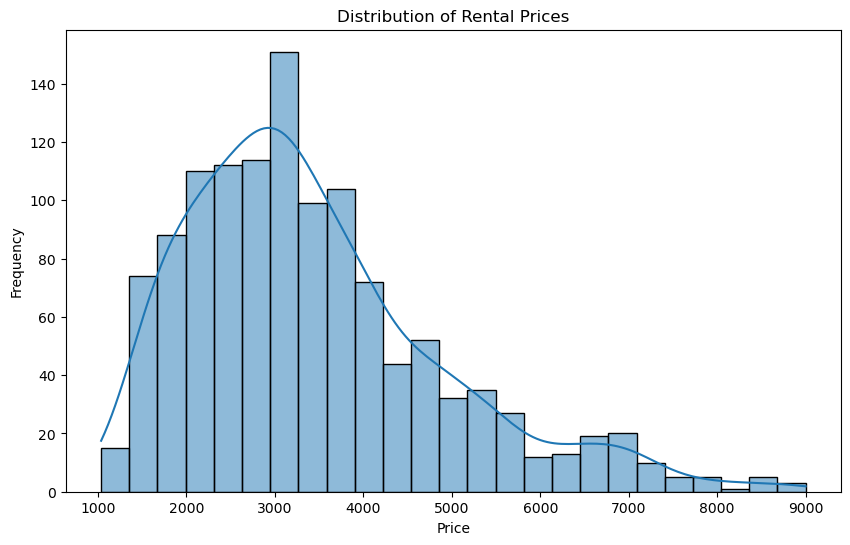

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


#Rent Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

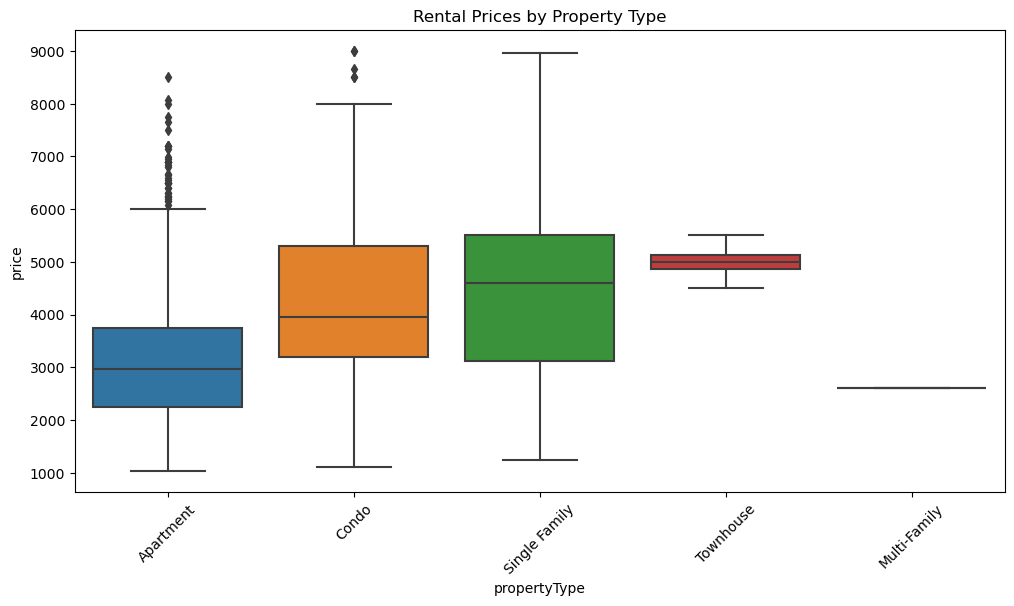

In [12]:
# Rent Price across Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='propertyType', y='price', data=df)
plt.title('Rental Prices by Property Type')
plt.xticks(rotation=45)
plt.show()

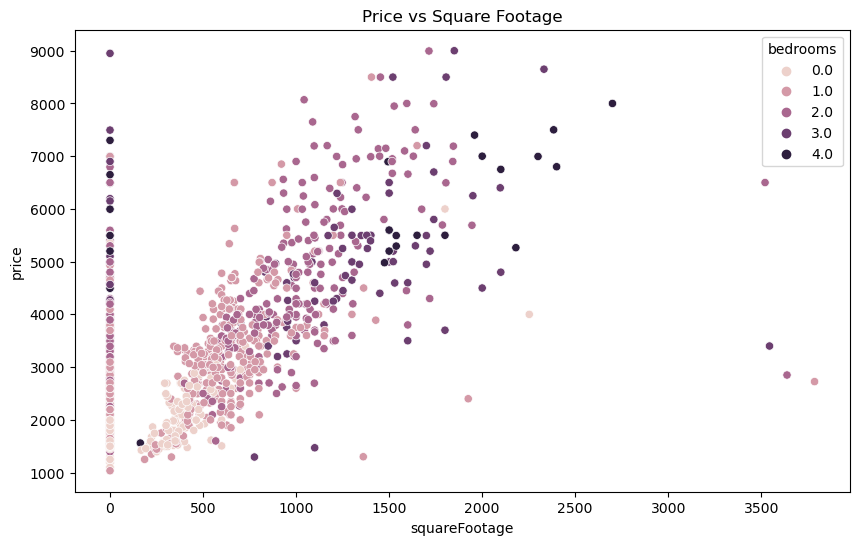

In [13]:
# Price vs Square Footage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='squareFootage', y='price', hue='bedrooms', data=df)
plt.title('Price vs Square Footage')
plt.show()

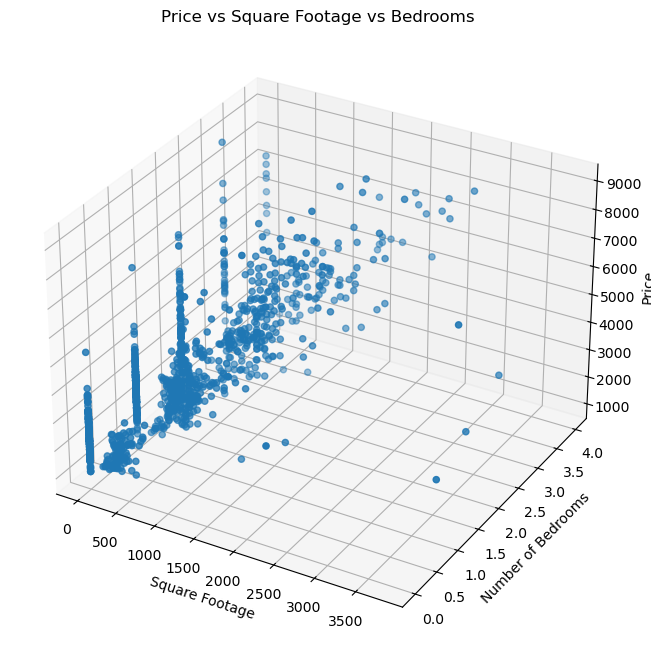

In [14]:
#Price vs Square Footage vs Bedrooms
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['squareFootage'], df['bedrooms'], df['price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('Price')
plt.title('Price vs Square Footage vs Bedrooms')
plt.show()

In [15]:
import folium
from folium.plugins import MarkerCluster
import webbrowser
import os


sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

marker_cluster = MarkerCluster().add_to(sf_map)

def get_color(price):
    if price < 2000:
        return 'green'
    elif price < 3000:
        return 'yellow'
    elif price < 4000:
        return 'orange'
    else:
        return 'red'


for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Price: ${row['price']}, Bedrooms: {row['bedrooms']}",
        color=get_color(row['price']),
        fill=True,
        fillColor=get_color(row['price'])
    ).add_to(marker_cluster)

legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 120px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; Price Legend <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i> &lt; $2000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:yellow"></i> $2000-$3000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i> $3000-$4000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i> &gt; $4000
</div>
'''
sf_map.get_root().html.add_child(folium.Element(legend_html))


map_file = "sf_rentals_map.html"
sf_map.save(map_file)


file_path = os.path.abspath(map_file)


webbrowser.open('file://' + file_path)

True

In [16]:
gmaps_places = googlemaps.Client(key=MAPS_API_KEY)
gmaps_geocoding = googlemaps.Client(key=GEOCODING_KEY)

def autocomplete_place(input_text):
    predictions = gmaps_places.places_autocomplete(input_text, types='geocode')
    return predictions

def get_lat_lng_from_place_id(place_id):
    result = gmaps_geocoding.place(place_id=place_id)
    location = result['result']['geometry']['location']
    return location['lat'], location['lng']


# Recommendation System

In [17]:
#functions for geocoding/sentimential analyzer

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

# Function to get sentiment score
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    return sia.polarity_scores(text)["compound"]

# Function to fetch Google Maps reviews
def fetch_reviews(place_id, max_reviews=100):
    reviews = []
    place_details = gmaps_places.place(place_id=place_id)
    if 'reviews' in place_details['result']:
        reviews.extend(place_details['result']['reviews'][:max_reviews])
    return reviews

# Example function to search for a place and get its place_id
def search_place(query):
    places_result = gmaps_places.places(query)
    if places_result['results']:
        return places_result['results'][0]['place_id']
    return None

# Function to analyze reviews and get sentiment scores for relevant features
def analyze_reviews(reviews):
    review_data = {
        "review_text": [review['text'] for review in reviews],
        "sentiment_score": [sentiment_score(review['text']) for review in reviews]
    }
    reviews_df = pd.DataFrame(review_data)
    avg_sentiment_score = reviews_df['sentiment_score'].mean()
    return avg_sentiment_score

# Cache to store place IDs and their sentiment scores
place_cache = {}

def get_reviews_for_listings(filtered_df, max_reviews_per_listing=100):
    filtered_df['place_id'] = filtered_df['formattedAddress'].apply(lambda x: place_cache.get(x, search_place(x)))
    filtered_df['sentiment_score'] = 0.0

    for index, row in filtered_df.iterrows():
        if row['place_id']:
            if row['place_id'] not in place_cache:
                reviews = fetch_reviews(row['place_id'], max_reviews=max_reviews_per_listing)
                if reviews:
                    avg_sentiment_score = analyze_reviews(reviews)
                    place_cache[row['place_id']] = avg_sentiment_score
                else:
                    place_cache[row['place_id']] = 0.0
            filtered_df.at[index, 'sentiment_score'] = place_cache[row['place_id']]
    return filtered_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/irisyu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# Hard Metric Recommendation

def calculate_score(row, criteria, weights):
    score = 0
    score += weights['bedrooms'] * (1 if row['bedrooms'] >= criteria['bedrooms'] else 0)
    score += weights['bathrooms'] * (1 if row['bathrooms'] >= criteria['bathrooms'] else 0)
    score += weights['price'] * (1 - row['price'])
    score += weights['distance'] * (1 - row['distance'])
    return score

def autocomplete_place(input_text):
    predictions = gmaps_places.places_autocomplete(input_text, types='geocode')
    return predictions

def get_lat_lng_from_place_id(place_id):
    result = gmaps_places.place(place_id=place_id)
    location = result['result']['geometry']['location']
    return location['lat'], location['lng']

def filter_listings(df, criteria, weights):
    df['original_price'] = df['price'].copy()
    filtered_df = df[
        (df['bedrooms'] >= criteria['bedrooms']) &
        (df['bathrooms'] >= criteria['bathrooms']) &
        (df['price'] >= criteria['min_rent']) &
        (df['price'] <= criteria['max_rent'])
    ].copy()
    
    if filtered_df.empty:
        print("No listings found that match your criteria.")
        return filtered_df

    try:
        predictions = autocomplete_place(criteria['location'])
        if predictions:
            place_id = predictions[0]['place_id']
            lat, lng = get_lat_lng_from_place_id(place_id)
            
            filtered_df['distance'] = filtered_df.apply(lambda row: haversine(lat, lng, row['latitude'], row['longitude']), axis=1)
            filtered_df = filtered_df[filtered_df['distance'] <= criteria['max_distance_km']]
        
        if not filtered_df.empty:
            scaler = MinMaxScaler()
            filtered_df[['price', 'distance']] = scaler.fit_transform(filtered_df[['price', 'distance']])
        
            filtered_df['score'] = filtered_df.apply(lambda row: calculate_score(row, criteria, weights), axis=1)
            filtered_df = filtered_df.sort_values('score', ascending=False)
        else:
            print("No listings found after applying distance filter.")
            return filtered_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()
    
    return filtered_df


In [19]:
def display_results(filtered_df):
    if filtered_df.empty:
        print("No listings found that match your criteria.")
    else:
        print(f"Found {len(filtered_df)} listings that match your criteria:")
        print(filtered_df[['formattedAddress', 'price', 'bedrooms', 'bathrooms', 'squareFootage', 'distance', 'score']])

In [20]:
def get_user_input():
    print("Let's find your ideal rental property!")
    
    criteria = {}
    weights = {}
    
    try:
        criteria['bedrooms'] = float(input("Enter number of bedrooms (e.g., 1, 2, 3): "))
        criteria['bathrooms'] = float(input("Enter number of bathrooms (e.g., 1, 1.5, 2): "))
        
        criteria['min_rent'] = float(input("Minimum rent price: "))
        criteria['max_rent'] = float(input("Maximum rent price: "))
        
        criteria['location'] = input("Enter desired location (you can input zip code, neighborhood, building name, or landmark): ")
        
        criteria['move_in_date'] = input("Enter moving-in date (YYYY-MM-DD): ")
        criteria['lease_term'] = int(input("Enter lease term (in months): "))
        
        criteria['max_distance_km'] = float(input("Enter maximum distance from the location (in kilometers): "))
        
        print("\nNow, let's set the importance of each criterion.")
        print("Please rate the importance of each criterion from 1 (least important) to 10 (most important):")
        
        weights['bedrooms'] = float(input("Importance of number of bedrooms: ")) / 10
        weights['bathrooms'] = float(input("Importance of number of bathrooms: ")) / 10
        weights['price'] = float(input("Importance of price: ")) / 10
        weights['distance'] = float(input("Importance of distance from desired location: ")) / 10
    except ValueError as e:
        print(f"Invalid input: {e}. Please enter numeric values where required.")
        return None, None
    
    return criteria, weights


In [21]:
def enhanced_filter_listings(filtered_df, soft_weights):
    if filtered_df.empty:
        print("No listings available for further filtering.")
        return filtered_df

    # Get reviews and analyze sentiment
    filtered_df = get_reviews_for_listings(filtered_df)

    # Calculate enhanced score
    filtered_df['enhanced_score'] = (
        filtered_df['score'] +
        filtered_df['sentiment_score'] * soft_weights['sentiment']
    )

    return filtered_df.sort_values('enhanced_score', ascending=False)
